In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, MaxPooling2D, Add, GlobalAveragePooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
import os
import cv2
from tensorflow.keras.applications import VGG16
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint

In [2]:
data_dir = "BUSI"
categories = [f.name for f in os.scandir(data_dir) if f.is_dir()]
print("Classes in the BUSI dataset:")
for folder in categories:
    print(folder)

Classes in the BUSI dataset:
benign
malignant
normal


In [3]:
images = []
labels = []

for category in categories:
    category_path = os.path.join(data_dir, category)
    class_num = categories.index(category)
    for img in os.listdir(category_path):
        img_path = os.path.join(category_path, img)
        img_array = cv2.imread(img_path, cv2.IMREAD_COLOR)
        img_array = cv2.resize(img_array, (224, 224))  
        images.append(img_array)
        labels.append(class_num)

images = np.array(images)
labels = np.array(labels)

In [4]:
# Split the dataset into train and test sets
num_samples, height, width, channels = images.shape
X_flat = images.reshape(num_samples, -1)  # Reshape to (samples, height*width*channels)
X_train, X_test, y_train, y_test = train_test_split(X_flat, labels, test_size=0.25, random_state=42)
X_train = X_train.reshape(-1, 224, 224, 3)

In [5]:
train_datagen = ImageDataGenerator(
    rotation_range=5,  # Rotate images by a maximum of 5 degrees
    width_shift_range=0.1,  # Shift images horizontally by 10% of the width
    height_shift_range=0.1,  # Shift images vertically by 10% of the height
    zoom_range=0.1,  # Zoom images by 10%
    horizontal_flip=True,  # Flip images horizontally
    vertical_flip=True
)

In [6]:
train_datagen.fit(X_train)
augmented_images = []
augmented_labels = []

augmentation_factor = 2
for x_batch, y_batch in train_datagen.flow(X_train, y_train, batch_size=len(X_train), shuffle=False):
    augmented_images.append(x_batch)
    augmented_labels.append(y_batch)
    if len(augmented_images) >= augmentation_factor:
        break

# Concatenate the augmented data batches
X_train = np.concatenate(augmented_images)
y_train = np.concatenate(augmented_labels)

print("Shape of augmented images:", X_train.shape)
print("Shape of augmented labels:", y_train.shape)
X_test = X_test.reshape(-1, 224, 224, 3)

Shape of augmented images: (1170, 224, 224, 3)
Shape of augmented labels: (1170,)


In [7]:
y_train = to_categorical(y_train, num_classes=3)
y_test = to_categorical(y_test, num_classes=3)

In [8]:
base_model = VGG16(include_top=False, input_shape=(224, 224, 3), pooling='max', weights='imagenet')

# Define the model
model = Sequential()
model.add(base_model)
model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())  # Batch Normalization layer
model.add(Dropout(0.5))
model.add(Dense(3, activation='softmax'))

for layer in base_model.layers:
    layer.trainable = False

# Unfreeze the last few layers for fine-tuning
for layer in base_model.layers[-4:]:
    layer.trainable = True

# Compile the model
optimizer = Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer,
                loss='categorical_crossentropy',
                metrics=['accuracy'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 512)               14714688  
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 flatten (Flatten)           (None, 512)               0         
                                                                 
 dense (Dense)               (None, 512)               262656    
                                                                 
 batch_normalization (Batch  (None, 512)               2048      
 Normalization)                                                  
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                        

In [9]:
checkpoint_path = 'vgg16.h5'
checkpoint = ModelCheckpoint(checkpoint_path,
                             monitor='val_accuracy',
                             verbose=1,
                             save_best_only=True,
                             mode='max',
                             save_weights_only=True)

history = model.fit(X_train,
                         y_train,
                         batch_size=32,
                         verbose=1,
                         epochs=50,
                         validation_data=(X_test, y_test),
                         shuffle=True,
                         callbacks=[checkpoint]
                     )

model.load_weights(checkpoint_path)

Epoch 1/50
37/37 [==============================] - ETA: 0s - loss: 1.8243 - accuracy: 0.3675 
Epoch 1: val_accuracy improved from -inf to 0.58163, saving model to vgg16.h5
37/37 [==============================] - 659s 18s/step - loss: 1.8243 - accuracy: 0.3675 - val_loss: 1.0439 - val_accuracy: 0.5816
Epoch 2/50
37/37 [==============================] - ETA: 0s - loss: 1.3912 - accuracy: 0.4778 
Epoch 2: val_accuracy improved from 0.58163 to 0.64796, saving model to vgg16.h5
37/37 [==============================] - 655s 18s/step - loss: 1.3912 - accuracy: 0.4778 - val_loss: 0.8694 - val_accuracy: 0.6480
Epoch 3/50
37/37 [==============================] - ETA: 0s - loss: 1.2699 - accuracy: 0.5333 
Epoch 3: val_accuracy improved from 0.64796 to 0.66327, saving model to vgg16.h5
37/37 [==============================] - 656s 18s/step - loss: 1.2699 - accuracy: 0.5333 - val_loss: 0.7831 - val_accuracy: 0.6633
Epoch 4/50
37/37 [==============================] - ETA: 0s - loss: 1.1419 - accur

Epoch 29/50
37/37 [==============================] - ETA: 0s - loss: 0.1312 - accuracy: 0.9590 
Epoch 29: val_accuracy did not improve from 0.84184
37/37 [==============================] - 420s 11s/step - loss: 0.1312 - accuracy: 0.9590 - val_loss: 0.6472 - val_accuracy: 0.8316
Epoch 30/50
37/37 [==============================] - ETA: 0s - loss: 0.1298 - accuracy: 0.9564 
Epoch 30: val_accuracy did not improve from 0.84184
37/37 [==============================] - 435s 12s/step - loss: 0.1298 - accuracy: 0.9564 - val_loss: 0.6788 - val_accuracy: 0.8061
Epoch 31/50
37/37 [==============================] - ETA: 0s - loss: 0.1421 - accuracy: 0.9521 
Epoch 31: val_accuracy did not improve from 0.84184
37/37 [==============================] - 449s 12s/step - loss: 0.1421 - accuracy: 0.9521 - val_loss: 0.6806 - val_accuracy: 0.7959
Epoch 32/50
37/37 [==============================] - ETA: 0s - loss: 0.1464 - accuracy: 0.9487 
Epoch 32: val_accuracy did not improve from 0.84184
37/37 [========

In [10]:
from sklearn.metrics import classification_report, confusion_matrix

# Evaluate the model on the test set
evaluation = model.evaluate(X_test, y_test, verbose=1)

# Generate predictions
predictions = model.predict(X_test)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = np.argmax(y_test, axis=1)

# Classification report and confusion matrix
print("Test Accuracy:", evaluation[1])

7/7 [==============================] - 54s 8s/step
Test Accuracy: 0.8520408272743225


1/1 [==============================] - 2s 2s/step


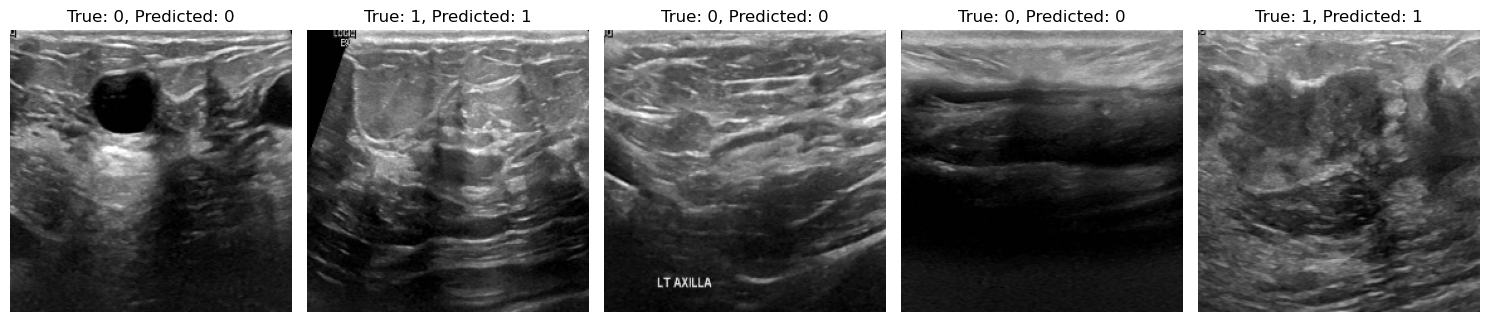

In [11]:
import numpy as np
import matplotlib.pyplot as plt

# Get some random indices from the test set
num_samples_to_display = 5  # Number of random samples to display
random_indices = np.random.choice(X_test.shape[0], num_samples_to_display, replace=False)

# Get the corresponding images, ground truth labels, and predicted labels
images_to_display = X_test[random_indices]
true_labels = y_test[random_indices]
predicted_labels = model.predict(images_to_display)
predicted_labels = np.argmax(predicted_labels, axis=1)

# Convert true_labels to integers because they are one-hot encoded
true_labels_int = np.argmax(true_labels, axis=1)

# Display the images along with their ground truth and predicted labels
plt.figure(figsize=(15, 5))
for i in range(num_samples_to_display):
    plt.subplot(1, num_samples_to_display, i + 1)
    plt.imshow(images_to_display[i].reshape(height, width, channels))
    plt.title(f"True: {true_labels_int[i]}, Predicted: {predicted_labels[i]}")
    plt.axis('off')
plt.tight_layout()
plt.show()

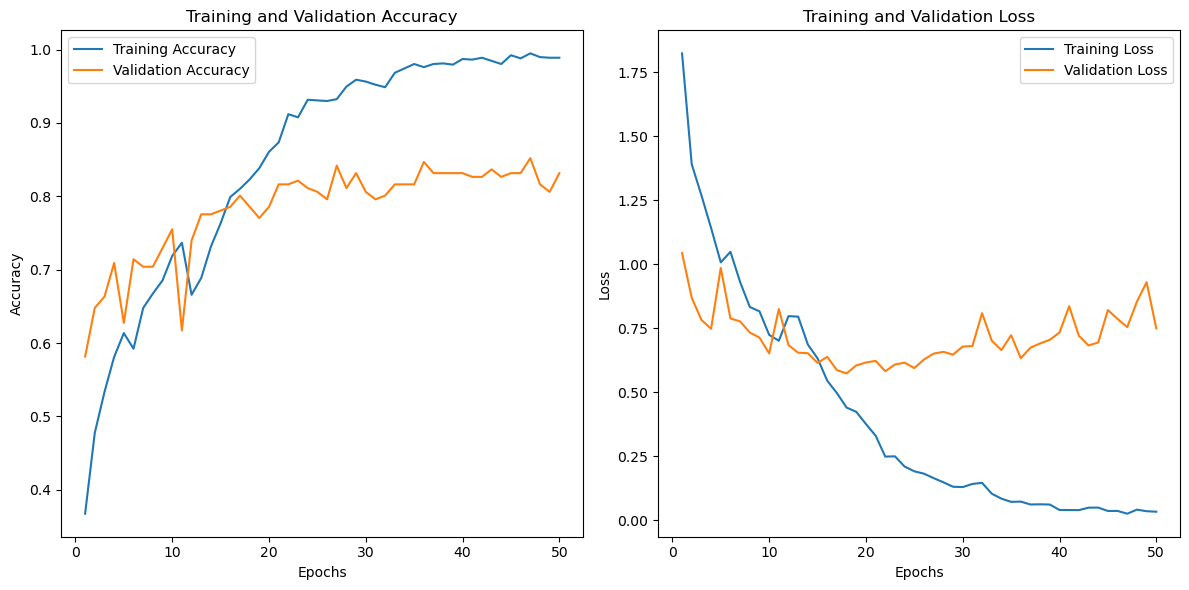

In [12]:
import matplotlib.pyplot as plt

# Extract accuracy and loss from the history object
train_loss = history.history['loss']
train_accuracy = history.history['accuracy']
val_loss = history.history['val_loss']
val_accuracy = history.history['val_accuracy']

epochs = range(1, len(train_loss) + 1)

# Plot training & validation accuracy values
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_accuracy, label='Training Accuracy')
plt.plot(epochs, val_accuracy, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(epochs, train_loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()